<a href="https://colab.research.google.com/github/tjp1992/ML-Jupyter/blob/main/Projects/03_Housing_Oreiley/Oreiley_Housing_ERD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# California Housing Prediction(Regression)

The following Notebook is intended to be used as personal study purposes.

---

## Framing the Problem

Realtors in California would like a solution for predicting the housing prices in different districts in California which would increase the efficiency when dealing with customers that have specific budget in mind.


Predict the housing prices of different districts in California based on the datasets

## Dataset
The following Dataset was retrieved from the github account of [ageron](https://github.com/ageron/handson-ml2), the author of [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).

In [1]:
# Following Cell was intended for importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit Learn importation
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit


# - library necessary for importation of the dataset
import os
import tarfile
import urllib

In [2]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master'
HOUSING_PATH = os.path.join('datasets','housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    """ Download the tgz file from the github repository and unpacking the dataset in to local path
    """
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def load_housing_data(housing_path = HOUSING_PATH):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(os.path.join(DOWNLOAD_ROOT, housing_path, "housing.csv"), parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df


In [3]:
housing_df = load_housing_data()
housing_df.head()

Memory usage of dataframe is 1.57 MB
Memory usage after optimization is: 0.41 MB
Decreased by 73.7%


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.25,37.87500,41.0,880.0,129.0,322.0,126.0,8.328125,452600.0,NEAR BAY
1,-122.25,37.87500,21.0,7100.0,1106.0,2400.0,1138.0,8.304688,358500.0,NEAR BAY
2,-122.25,37.84375,52.0,1467.0,190.0,496.0,177.0,7.257812,352100.0,NEAR BAY
3,-122.25,37.84375,52.0,1274.0,235.0,558.0,219.0,5.644531,341300.0,NEAR BAY
4,-122.25,37.84375,52.0,1627.0,280.0,565.0,259.0,3.845703,342200.0,NEAR BAY


In [4]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float16 
 1   latitude            20640 non-null  float16 
 2   housing_median_age  20640 non-null  float16 
 3   total_rooms         20640 non-null  float16 
 4   total_bedrooms      20433 non-null  float16 
 5   population          20640 non-null  float16 
 6   households          20640 non-null  float16 
 7   median_income       20640 non-null  float16 
 8   median_house_value  20640 non-null  float32 
 9   ocean_proximity     20640 non-null  category
dtypes: category(1), float16(8), float32(1)
memory usage: 423.6 KB


From `housing_df.info()`, one can see that the `ocean_proximity` column of the dataframe is an `object` column, but with the memory reduction function, it has been converted into `category` dtype.

`value_counts()` can be used on the column to see the number of categories of a specific column, in the following case, there are 4 different categories for `ocean_proximity`

In [5]:
housing_df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing_df.describe(include='all')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,2.064000e+04,2.064000e+04,2.064000e+04,20640.00,20433.0,20640.0,20640.0,2.064000e+04,20640.00000,20640
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1H OCEAN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9136
mean,-inf,inf,inf,inf,inf,inf,inf,inf,206854.96875,NaN
std,2.003906e+00,2.136719e+00,1.258594e+01,inf,inf,inf,inf,1.899414e+00,115395.18750,NaN
min,-1.243750e+02,3.253125e+01,1.000000e+00,2.00,1.0,3.0,1.0,5.000000e-01,14999.00000,NaN
25%,-1.218125e+02,3.393750e+01,1.800000e+01,1447.75,296.0,787.0,280.0,2.563965e+00,119600.00000,NaN
50%,-1.185000e+02,3.425000e+01,2.900000e+01,2128.00,435.0,1166.0,409.0,3.535156e+00,179700.00000,NaN
75%,-1.180000e+02,3.771875e+01,3.700000e+01,3148.00,647.0,1725.0,605.0,4.742188e+00,264725.00000,NaN


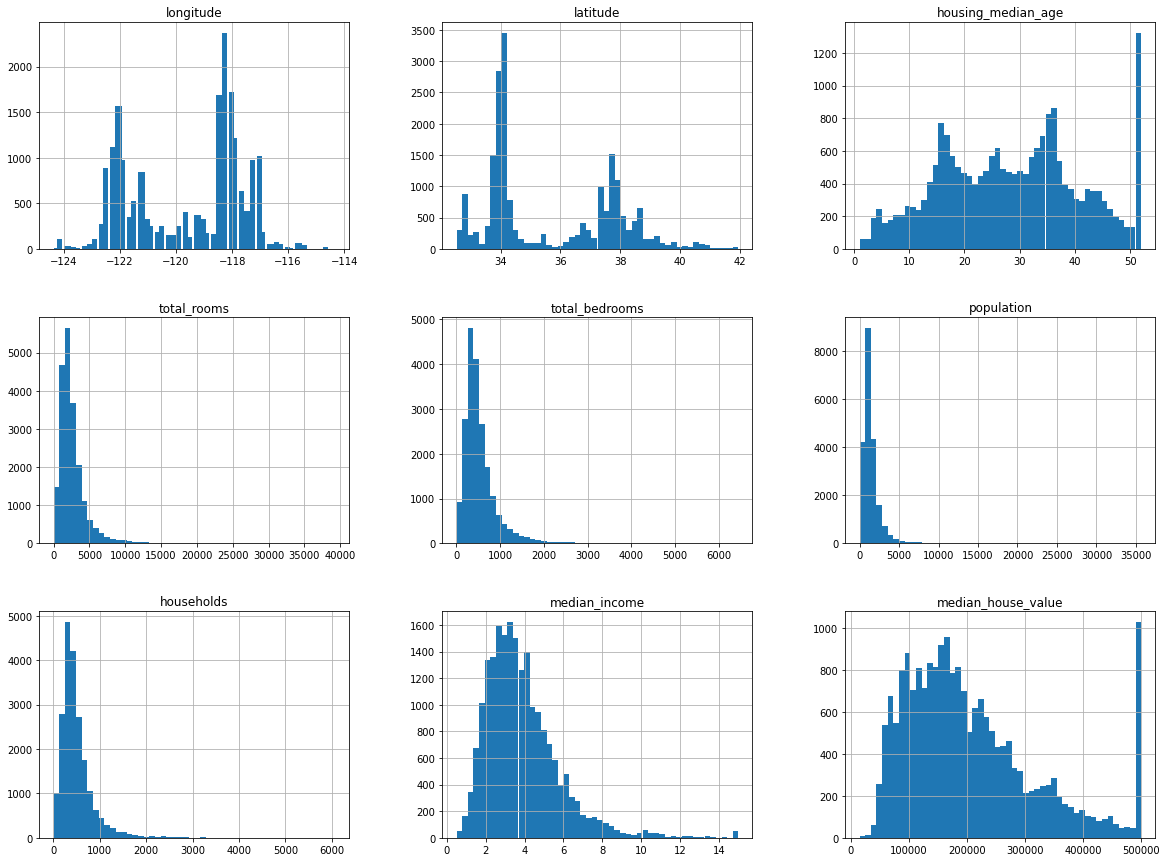

In [7]:
housing_df.hist(bins=50, figsize=(20,15))
plt.show();

`median_income` column value does not look normal, as the income cannot be ranged between 1~15. However, in the documentation for the dataset, we can conclude that the values are indeed scaled with the max of 15 being 150,000.

The following dataset is not yet divided into test set and training set. We can use `train_test_split` method provided by [sklearn](https://scikit-learn.org/stable/index.html), but that would create a bias in the following case, as the `median_income` is a collection of different incomes, but doesn't take into consideration the sex of the data. In the following case, we can use `StratifiedShuffleSplit` from `sklearn` which uses [stratefied sampling](https://en.wikipedia.org/wiki/Stratified_sampling)

In [8]:
housing_df['income_cat'] = pd.cut(housing_df['median_income'], bins=[0., 1.5, 3., 4.5, 6., np.inf], labels = [1,2,3,4,5])

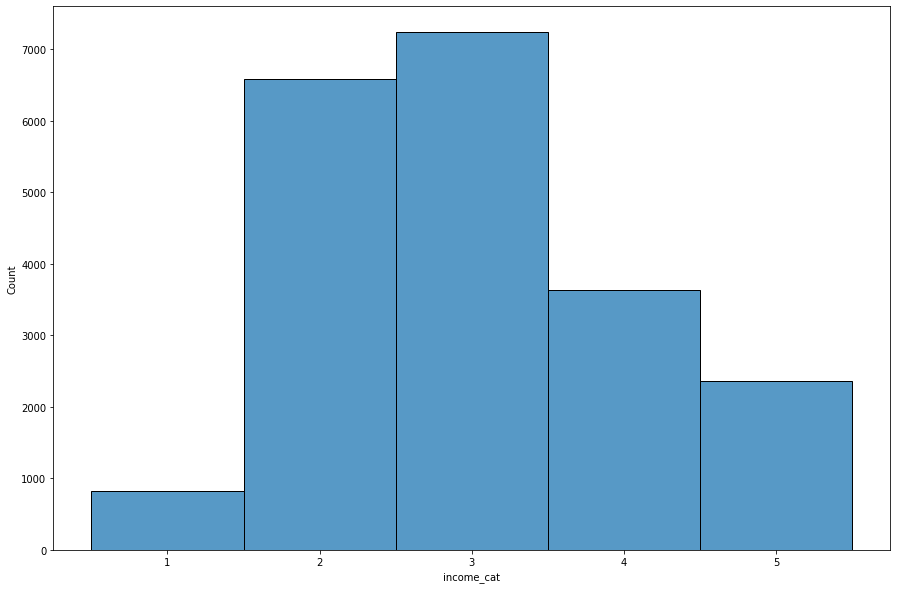

In [9]:
plt.figure(figsize=(15,10))
sns.histplot(housing_df['income_cat'])

In [10]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_df, housing_df['income_cat']):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]

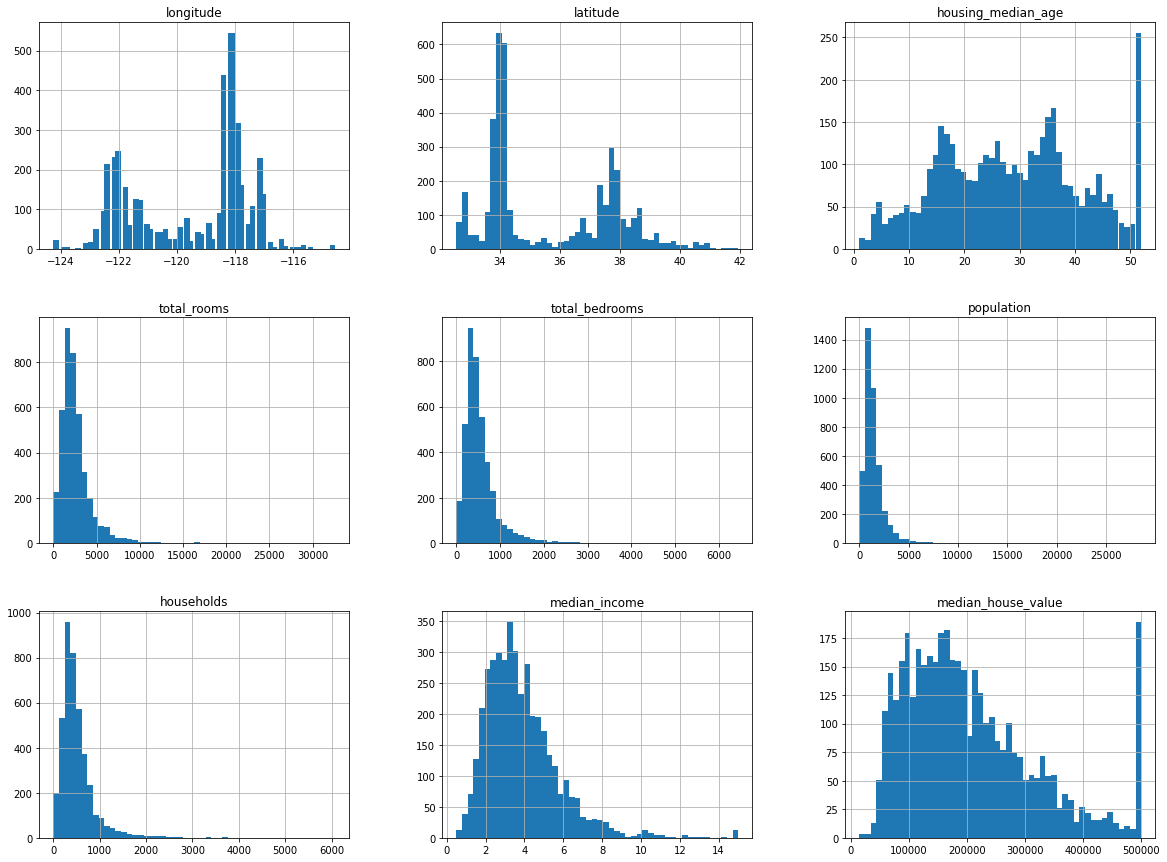

In [11]:
strat_test_set.hist(bins=50,figsize=(20,15));

In [12]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop('income_cat',axis=1, inplace=True)

housing = strat_train_set.copy()

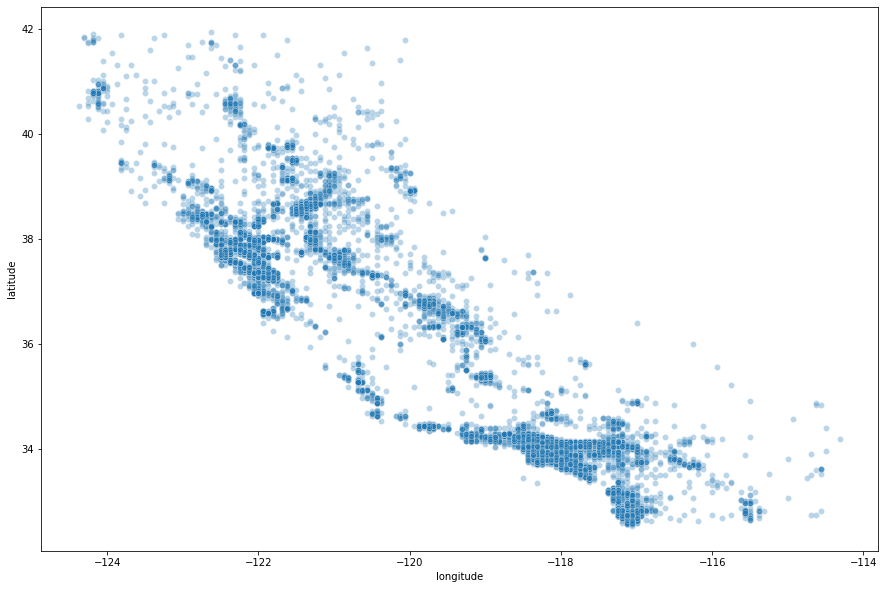

In [13]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=housing, x='longitude', y='latitude', alpha=0.3);

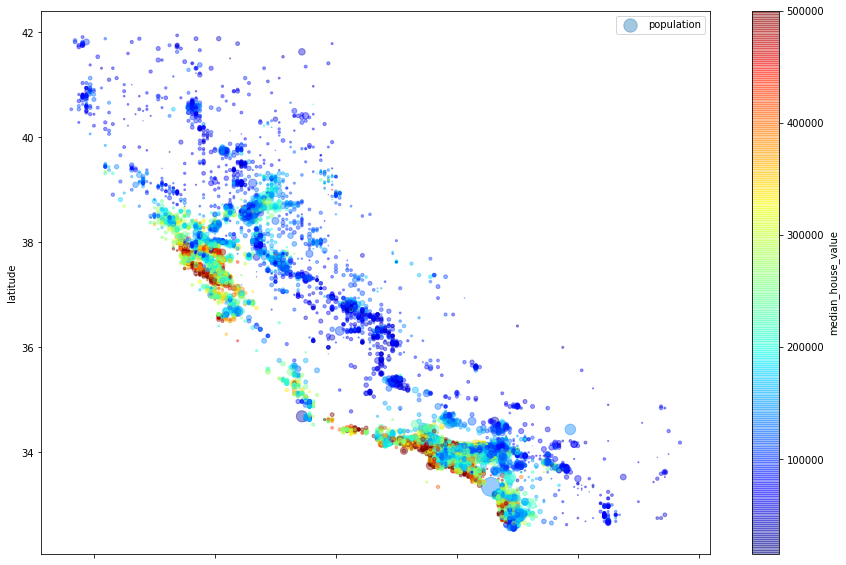

In [14]:
housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.4,
    s=housing['population']/100,
    label='population',
    figsize=(15,10),
    c='median_house_value',
    cmap=plt.get_cmap('jet'),
    colorbar=True

)

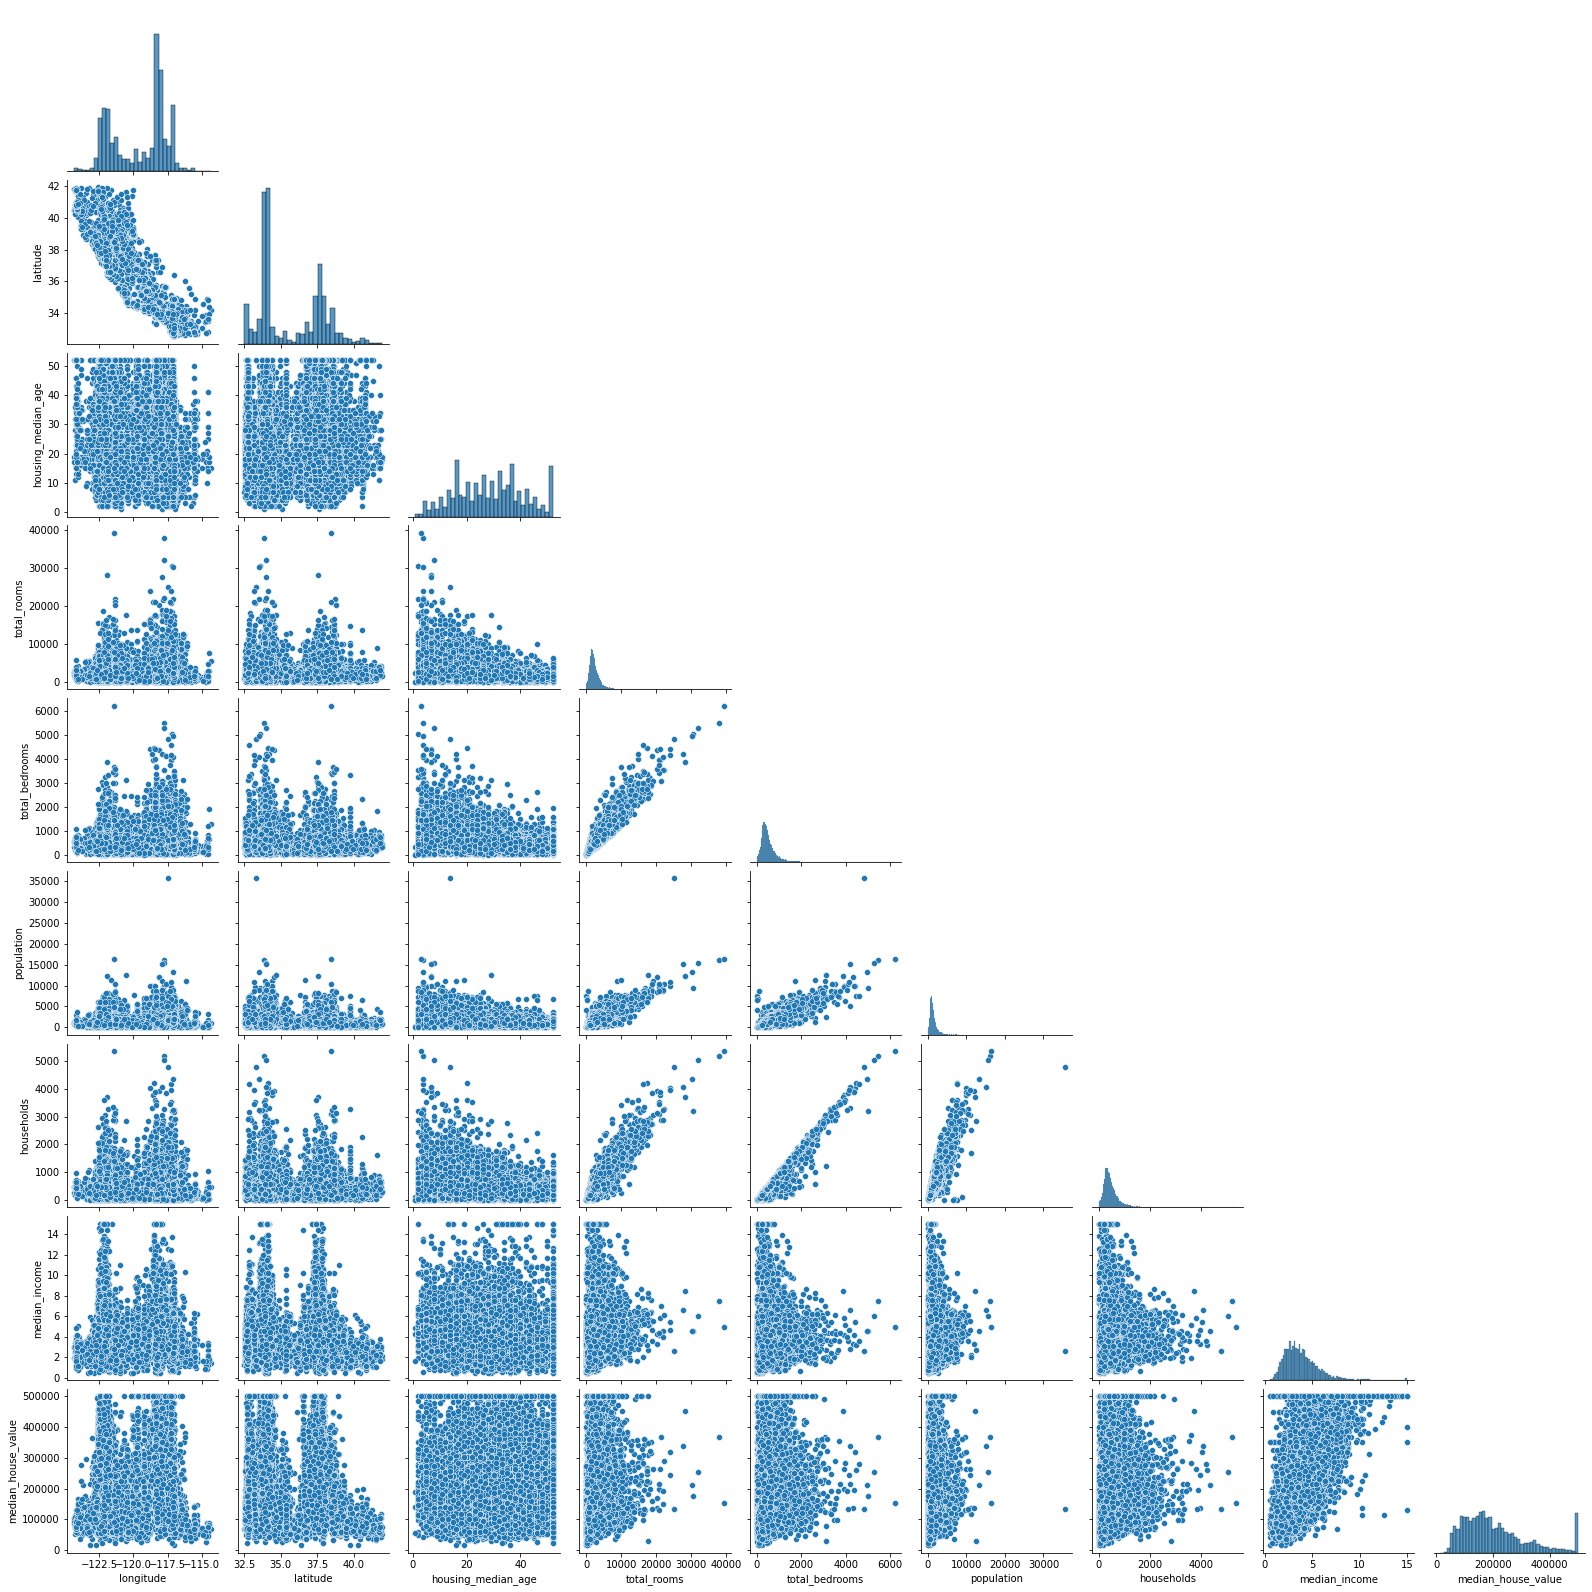

In [15]:
sns.pairplot(housing,corner=True)

In [16]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924410,-0.105784,0.048863,0.076561,0.107975,0.063046,-0.019554,-0.047557
latitude,-0.924410,1.000000,0.005764,-0.039244,-0.072534,-0.115328,-0.077749,-0.075159,-0.142624
housing_median_age,-0.105784,0.005764,1.000000,-0.364532,-0.325103,-0.298739,-0.306475,-0.111318,0.114146
total_rooms,0.048863,-0.039244,-0.364532,1.000000,0.929388,0.855098,0.918394,0.200129,0.135137
total_bedrooms,0.076561,-0.072534,-0.325103,0.929388,1.000000,0.876323,0.980169,-0.009641,0.047784
population,0.107975,-0.115328,-0.298739,0.855098,0.876323,1.000000,0.904633,0.002421,-0.026882
households,0.063046,-0.077749,-0.306475,0.918394,0.980169,0.904633,1.000000,0.010871,0.064590
median_income,-0.019554,-0.075159,-0.111318,0.200129,-0.009641,0.002421,0.010871,1.000000,0.687148
median_house_value,-0.047557,-0.142624,0.114146,0.135137,0.047784,-0.026882,0.064590,0.687148,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efc2ea85350>,
      dtype=object)

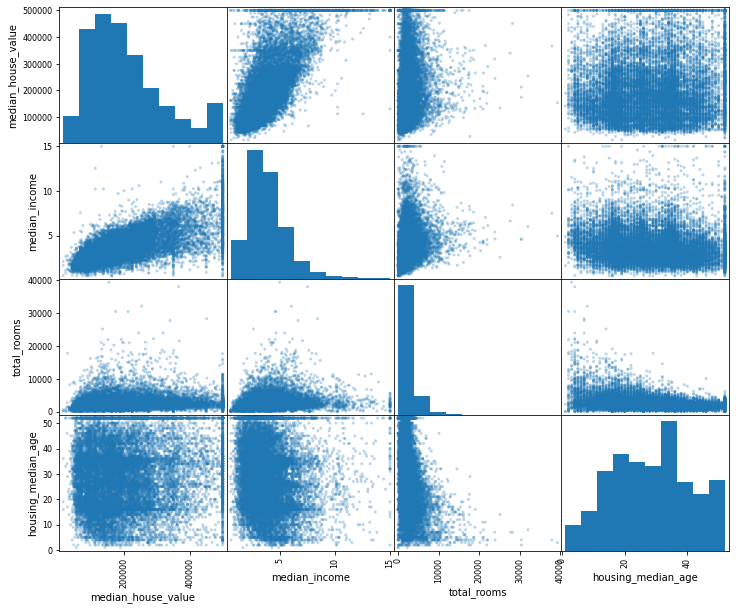

In [17]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(housing[attributes], alpha=0.3, figsize=(12,10))

<Figure size 864x720 with 0 Axes>

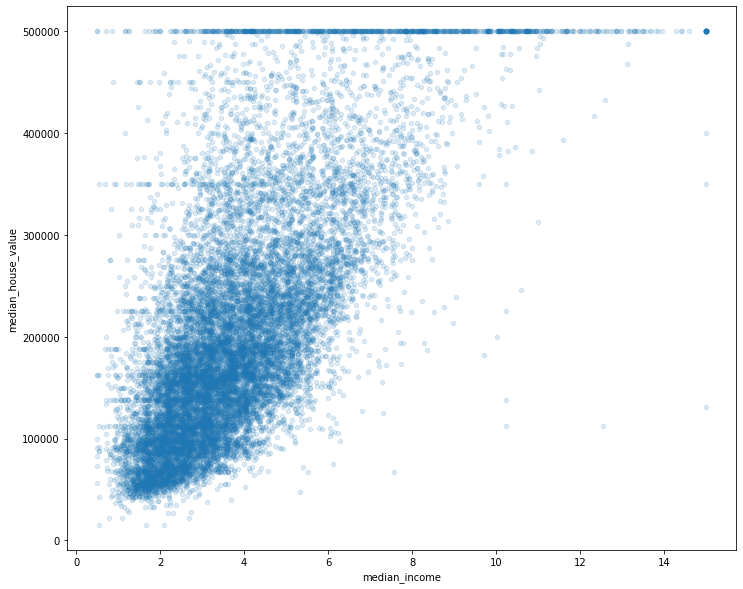

In [18]:
plt.figure(figsize=(12,10))
housing.plot(kind='scatter', x='median_income',y='median_house_value', alpha=0.15, figsize=(12,10));
# sns.scatterplot(data=housing, x='median_income',y='median_house_value', alpha=0.15);
plt.show()

In [19]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [20]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687148
rooms_per_household         0.146260
total_rooms                 0.135137
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047784
population_per_household   -0.021993
population                 -0.026882
longitude                  -0.047557
latitude                   -0.142624
bedrooms_per_room          -0.259947
Name: median_house_value, dtype: float64

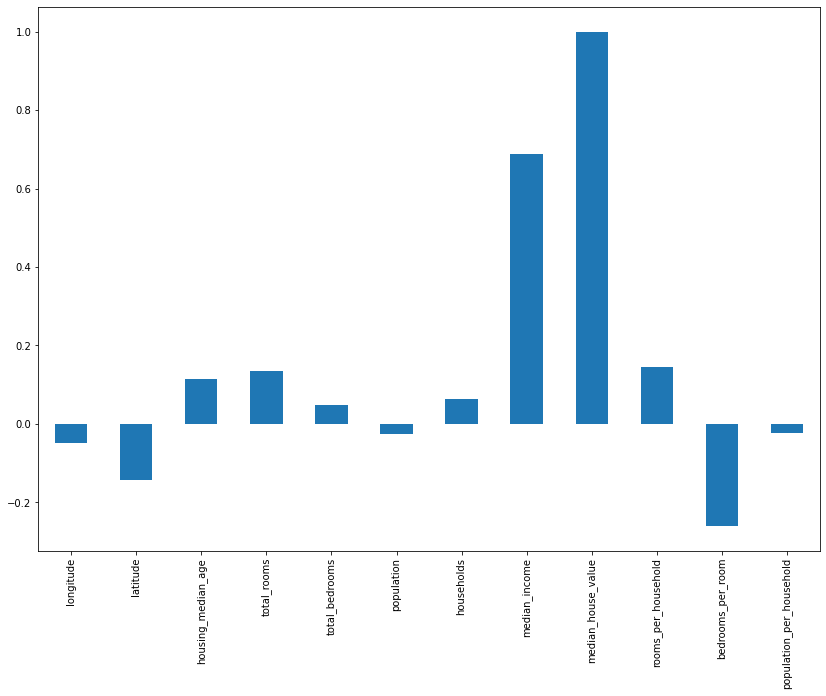

In [21]:
corr_matrix['median_house_value'].plot(kind='bar', figsize=(14,10));

In [25]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [26]:
housing_num = housing.drop("ocean_proximity",axis=1)

X = imputer.fit_transform(housing_num)
X

array([[-121.4375    ,   38.53125   ,   29.        , ...,    5.484375  ,
           0.20581055,    3.1679688 ],
       [-117.25      ,   33.09375   ,    7.        , ...,    6.9257812 ,
           0.1607666 ,    2.6230469 ],
       [-119.0625    ,   35.375     ,   44.        , ...,    5.3945312 ,
           0.19165039,    2.2226562 ],
       ...,
       [-122.75      ,   38.4375    ,   48.        , ...,    4.109375  ,
           0.23474121,    2.6621094 ],
       [-122.6875    ,   38.3125    ,   14.        , ...,    6.3007812 ,
           0.18383789,    2.4121094 ],
       [-122.125     ,   39.96875   ,   27.        , ...,    5.4765625 ,
           0.20568848,    3.171875  ]], dtype=float32)

In [27]:
housing_tr = pd.DataFrame(X, columns= housing_num.columns, index = housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
12655,-121.4375,38.53125,29.0,3872.0,797.0,2236.0,706.0,2.173828,72100.0,5.484375,0.205811,3.167969
15502,-117.2500,33.09375,7.0,5320.0,855.0,2015.0,768.0,6.335938,279600.0,6.925781,0.160767,2.623047
2908,-119.0625,35.37500,44.0,1618.0,310.0,667.0,300.0,2.875000,82700.0,5.394531,0.191650,2.222656
14053,-117.1250,32.75000,24.0,1877.0,519.0,898.0,483.0,2.226562,112500.0,3.886719,0.276611,1.859375
20496,-118.6875,34.28125,27.0,3536.0,646.0,1837.0,580.0,4.496094,238300.0,6.097656,0.182739,3.167969


## Custom Transformer

The ability to make `custom transformer` is essential in order to customize the automation process of the pipeline. [Scikit Learn](https://scikit-learn.org/stable/index.html) provides it's default transformers with methods for customizing `hyperparameters` 

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAddr(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        rooms_per_household = X[:,rooms_ix] / X[:,households_ix]
        population_per_household = X[:,population_ix] / X[:,households_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:,rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAddr(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [58]:
cols = list(housing.columns)
for _ in ['rooms_per_household','population_per_household']:
    cols.append(_)
pd.DataFrame(housing_extra_attribs, columns=cols)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,rooms_per_household,population_per_household
0,-121.4375,38.53125,29.0,3872.0,797.0,2236.0,706.0,2.173828,72100.0,INLAND,5.484375,0.205811,3.167969,5.484419,3.167139
1,-117.25,33.09375,7.0,5320.0,855.0,2015.0,768.0,6.335938,279600.0,NEAR OCEAN,6.925781,0.160767,2.623047,6.927083,2.623698
2,-119.0625,35.375,44.0,1618.0,310.0,667.0,300.0,2.875,82700.0,INLAND,5.394531,0.19165,2.222656,5.393333,2.223333
3,-117.125,32.75,24.0,1877.0,519.0,898.0,483.0,2.226562,112500.0,NEAR OCEAN,3.886719,0.276611,1.859375,3.886128,1.859213
4,-118.6875,34.28125,27.0,3536.0,646.0,1837.0,580.0,4.496094,238300.0,<1H OCEAN,6.097656,0.182739,3.167969,6.096552,3.167241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,-117.0625,33.03125,14.0,6664.0,1231.0,2026.0,1001.0,5.089844,268500.0,<1H OCEAN,6.65625,0.184692,2.023438,6.657343,2.023976
16508,-121.4375,38.5,15.0,7900.0,1422.0,4768.0,1418.0,2.814453,90400.0,INLAND,5.570312,0.180054,3.363281,5.571227,3.362482
16509,-122.75,38.4375,48.0,707.0,166.0,458.0,172.0,3.179688,140400.0,<1H OCEAN,4.109375,0.234741,2.662109,4.110465,2.662791
16510,-122.6875,38.3125,14.0,3156.0,580.0,1208.0,501.0,4.195312,258100.0,<1H OCEAN,6.300781,0.183838,2.412109,6.299401,2.411178


(16512, 15)